In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "\\datasets\\covenant_lolbin_wuauclt_createremotethread_2020-10-12183248.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

df.shape

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


(1326, 166)

In [2]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df


# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data

# split the training and testing sets manually, make sure that positive data is in the testing set
def train_test_split_m(X, y, positive_list, test_size=0.33):

    sample_len = int(len(X) * 0.33 - len(positive_list))
    
    X_test = X.iloc[positive_list]
    X = X.drop(positive_list)
    
    X_random = X.sample(sample_len)
    X = X.drop(X_random.index)
    X_test = pd.concat([X_test, X_random], axis=0, ignore_index=True)
    y_test = list([1 for i in range(len(positive_list))] + [0 for i in range(sample_len)])

    X_train = X
    y_train = [0 for i in range(len(X_train))]
    
    return (X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
features = ["Channel", "EventID", "Image", "CommandLine", "Signed", "SourceImage", "ImageLoaded", "TargetFilename", "SourceProcessGuid", "ProcessGuid"]
df = df[features]
    
# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(1326, 10)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [5]:
from sdv.tabular import CTGAN

# model = CTGAN(cuda=True)
# model.fit(df)
# # save and reuse the model
# model.save('WuaucltCreateRemoteThread.pkl')

model = CTGAN.load(r'models\WuaucltCreateRemoteThread.pkl')

In [6]:
new_data = model.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,Image,CommandLine,Signed,SourceImage,ImageLoaded,TargetFilename,SourceProcessGuid,ProcessGuid
0,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,true,NaN,NaN,NaN,NaN,{029f9482-bfb1-5f84-5300-000000000400}
1,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\conhost.exe,NaN,NaN,C:\windows\system32\svchost.exe,C:\Windows\System32\powrprof.dll,NaN,NaN,{71b87c12-d96c-5f84-1601-000000000500}
2,Microsoft-Windows-Sysmon/Operational,5158,NaN,"""cmd.exe"" /c C:\Windows\System32\wuauclt.exe /...",true,NaN,NaN,NaN,NaN,NaN
3,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Microsoft-Windows-Sysmon/Operational,4689,NaN,NaN,NaN,C:\windows\system32\lsass.exe,C:\Windows\System32\perfos.dll,C:\Windows\ServiceState\EventLog\Data\lastaliv...,NaN,NaN


In [7]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# count_items(preprocess_labelEncoder(new_data))

## Use hunter program on new data

In [9]:
# Analytic I
I = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '1')
    & (new_data['Image'].str.lower().str.endswith('wuauclt.exe', na=False))
    & (new_data['CommandLine'].str.lower().str.contains('.*wuauclt.*updatedeploymentprovider.*.dll.*runhandlercomserver.*', regex=True))
]
)
len(I)

40

In [10]:
# Analytic II
II  = (
new_data[features]
    
[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (new_data['Image'].str.lower().str.endswith('wuauclt.exe', na=False))
    & (new_data['Signed'] == 'false')
]
)
II

,Channel,EventID,Image,CommandLine,Signed,SourceImage,ImageLoaded,TargetFilename,SourceProcessGuid,ProcessGuid
10415,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,C:\Windows\System32\combase.dll,NaN,NaN,{71b87c12-d7e5-5f84-0d01-000000000500}
25996,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,C:\Windows\System32\apphelp.dll,NaN,NaN,{71b87c12-d255-5f84-0c00-000000000500}
73288,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,C:\Windows\System32\dnsapi.dll,NaN,NaN,{71b87c12-d9fe-5f84-1801-000000000500}
83120,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,NaN,NaN,NaN,NaN
90929,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,NaN,NaN,NaN,{71b87c12-d9fe-5f84-1a01-000000000500}
...,...,...,...,...,...,...,...,...,...,...
973392,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,NaN,NaN,NaN,NaN
979741,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,NaN,NaN,NaN,NaN
981583,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,C:\Windows\System32\perfctrs.dll,NaN,NaN,{71b87c12-d9fe-5f84-1a01-000000000500}
987734,Microsoft-Windows-Sysmon/Operational,7,C:\Windows\System32\wuauclt.exe,NaN,false,NaN,NaN,NaN,NaN,{029f9482-bf9e-5f84-0c00-000000000400}


In [12]:
# Analytic III
III = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '8')
    & (new_data['SourceImage'].str.lower().str.endswith('wuauclt.exe', na=False))
]
)
len(III)

55

In [16]:
# Analytic IV
imageLoadDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (new_data['Image'].str.lower().str.endswith('wuauclt.exe', na=False))
]
)

fileCreateDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '11')
]
)

# (
# pd.merge(imageLoadDf, fileCreateDf,
#     left_on = 'ImageLoaded', right_on = 'TargetFilename', how = 'inner')
# )
IV = (
imageLoadDf[features]

[(imageLoadDf['ImageLoaded'].isin(fileCreateDf['TargetFilename']))
    & (imageLoadDf['ImageLoaded'])
]
)
len(IV)

8

In [25]:
# Analytic V
imageLoadDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (new_data['Image'].str.lower().str.endswith('wuauclt.exe', na=False))
]
)

fileCreateDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '11')
]
)

# firstJoinDf = (
# pd.merge(imageLoadDf, fileCreateDf,
#     left_on = 'ImageLoaded', right_on = 'TargetFilename', how = 'inner')
# )
firstJoinDf = (
imageLoadDf[features]

[(imageLoadDf['ImageLoaded'].isin(fileCreateDf['TargetFilename']))
    & (imageLoadDf['ImageLoaded'])
]
)

createRTDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '8')
    & (new_data['SourceImage'].str.lower().str.endswith('wuauclt.exe', na=False))
]
)

# (
# pd.merge(firstJoinDf, createRTDf,
#     left_on = 'ProcessGuid_x', right_on = 'SourceProcessGuid', how = 'inner')
# )
V = (
createRTDf[features]

[(createRTDf['SourceProcessGuid'].isin(firstJoinDf['ProcessGuid']))
    & (createRTDf['SourceProcessGuid'])]
)
print(len(firstJoinDf), len(createRTDf), len(V))

8 55 0


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [26]:
# randomly pick from results of analytics
results = [I, II, III, IV]
pick_nums = [40, 85, 55, 8] # 6000
gen_data = random_generator(results, pick_nums)

gen_data.shape

(188, 10)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Training with original data

Balanced accuracy score: 0.50


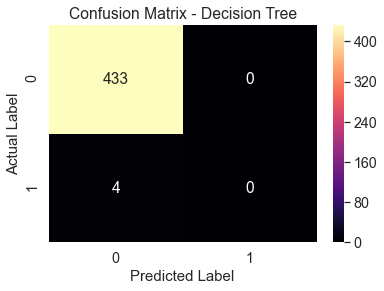

<Figure size 720x504 with 0 Axes>

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       433
           1       0.00      0.00      0.00         4

    accuracy                           0.99       437
   macro avg       0.50      0.50      0.50       437
weighted avg       0.98      0.99      0.99       437



In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess(df)
X, le_dict = labelEncoder_get(X) # record the label encoders for next step
y = labelList(df.shape[0], [593, 612, 613, 87])
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split_m(X, y, [593, 612, 613, 87])

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Training with original data and generated data
Generated data should only be added into trianing set.

Label encoder need to be recorded, otherwise training sets and testing sets may have different labels.

Balanced accuracy score: 0.87


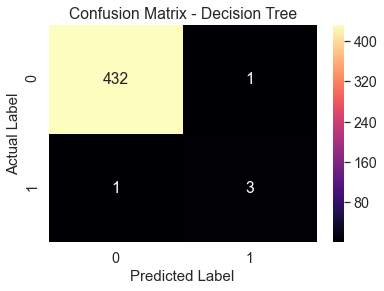

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       433
           1       0.75      0.75      0.75         4

    accuracy                           1.00       437
   macro avg       0.87      0.87      0.87       437
weighted avg       1.00      1.00      1.00       437



In [30]:
# preprocess the datasets
X_gen = preprocess(gen_data)
X_gen = labelEncoder_trans(X_gen, le_dict)
    
# add generated data to the original training set
X_train_new = pd.concat([X_train, X_gen], axis=0)

# generated data are all positive, y are all 1
for i in range(len(gen_data)):
    y_train.append(1)

clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test)

print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

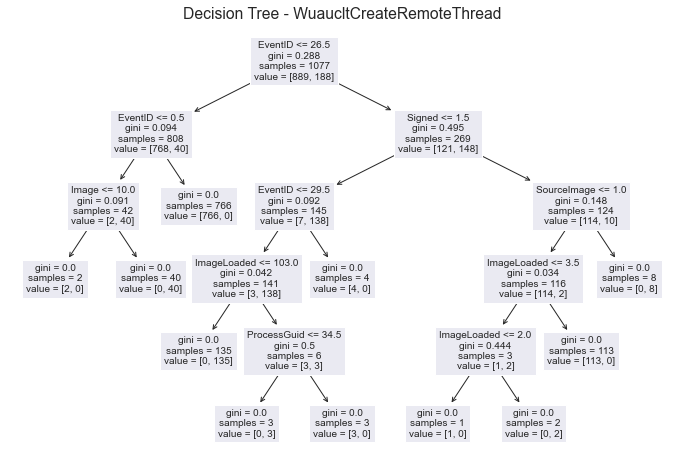

In [35]:
# draw the tree
from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - WuaucltCreateRemoteThread")
plt.savefig(r'DecisionTree\WuaucltCreateRemoteThread.png', dpi=100, transparent=True)

### Training with generated data
Since there are too few positive data, we put all of them into testing sets.

In [ ]:
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

## Save generated data

In [36]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + r'\generated_datasets\covenant_lolbin_wuauclt_createremotethread_new.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\empire_dllinjection_LoadLibrary_CreateRemoteThread_new.json")
# dataset.head()